In [1]:
import torch
from torch import optim,nn
from torch.autograd import Variable
import numpy as np
import time
import os
os.chdir('/home/mjc/github/EHRVis/')
from models.data_loader import DataLoader
from models.retain_bidirectional import RETAIN

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [36]:
model = torch.load('data/saved_weights/retain_bi_5000.pth')
model.eval()
model.release=True

In [4]:
import pickle
with open('data/preprocessed/2014_out_dict.pckl','rb') as f:
    out_dict = pickle.load(f)

In [44]:
jid = 12
input_list = []
targets = []
for tup in out_dict[jid]:
    input_list.append(tup[2])
    targets.append(tup[3])
input_list = [input_list]
targets = [targets]

In [45]:
inputs = model.list_to_tensor(input_list)
outputs = model(inputs)
targets = torch.LongTensor(targets).view(len(inputs),-1)[:,-1] # to only use last of each sequence
top5 = outputs.topk(5)[1].data
print("Top 5 predictions: ",top5)
print("Answer: ", targets[0])

Top 5 predictions:  
 132  139  136  184  101
[torch.cuda.LongTensor of size 1x5 (GPU 0)]

Answer:  132


/home/mjc/github/EHRVis/models/retain_bidirectional.py:35: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  outputs1 = self.RNN1(embedded) # [b x seq x 128*2]
/home/mjc/github/EHRVis/models/retain_bidirectional.py:43: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  outputs2 = self.RNN2(embedded) # [b x seq x 128]


In [92]:
# create random list
x_val = list(np.random.uniform(0,1,1400))
y_val = list(np.random.uniform(0,1,1400))
pos = dict()
for i in range(1400):
    pos[i]=[x_val[i],y_val[i]]

In [76]:
# calculate scores for top5
import numpy as np
scores = np.zeros((5,1400))
for t,pred in enumerate(top5.tolist()[0]):
    for v,visit in enumerate(input_list[0]):
        for i in visit:
            val = model.interpret(0,v,i,pred).data[0]
            scores[t,i] += val

In [143]:
# create edge list
edge_list = []
for t,pred in enumerate(top5.tolist()[0][0:1]):
    pred += 500 # to fit to index of 1400 items
    for i in range(1400):
        val = scores[t,i]
        if np.absolute(val)>0.01:
            edge_list.append((i,pred,{'Weight':val}))
G = nx.Graph()
G.add_edges_from(edge_list)

In [144]:
# import networkx
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [145]:
# add features
edge_width = [1*np.absolute(G[u][v]['Weight']) for u,v in G.edges()]
edge_color = []
for u,v in G.edges():
    if G[u][v]['Weight']>0:
        edge_color.append('r')
    else:
        edge_color.append('b')
node_color = []
for n in G.nodes():
    if n<500:
        c = 'g'
    elif n<768:
        c = 'r'
    else:
        c - 'y'
    node_color.append(c)

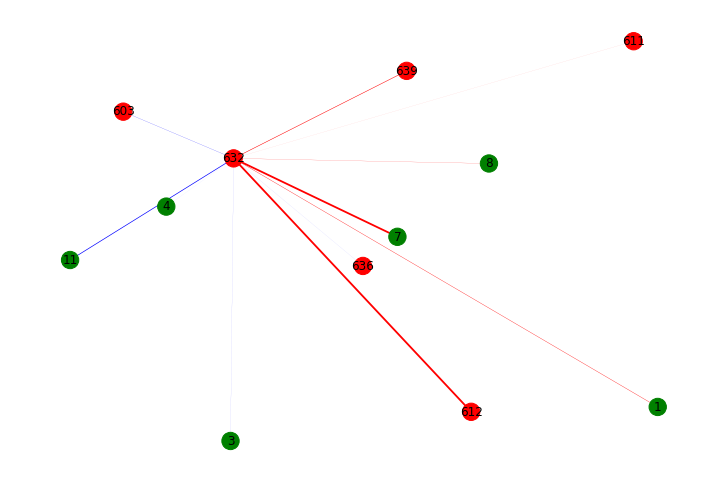

In [146]:
plt.figure(figsize=(10,7))
plt.axis('off')
plt.tight_layout()
nx.draw_networkx(G,pos, width=edge_width, edge_color=edge_color, node_color=node_color)

In [156]:
weights = model.emb.cpu().data.numpy()

In [160]:
sqrt = np.sqrt(np.multiply(weights,weights).sum(1))

In [166]:
normalized_weights = []
for i,row in enumerate(weights):
    normalized_weights.append(row/sqrt[i])
normalized_weights = np.array(normalized_weights)

In [174]:
sim = np.matmul(normalized_weights,normalized_weights.transpose())

In [175]:
plt.

array([[ 0.99999964,  0.07050041,  0.15158258, ..., -0.16219682,
         0.01788227,  0.03803807],
       [ 0.07050041,  0.99999988,  0.09286439, ...,  0.00698837,
        -0.25490147, -0.04863826],
       [ 0.15158258,  0.09286439,  1.00000036, ...,  0.00271488,
         0.10594503,  0.0134569 ],
       ..., 
       [-0.16219682,  0.00698837,  0.00271488, ...,  0.99999988,
        -0.00309024,  0.05490997],
       [ 0.01788227, -0.25490147,  0.10594503, ..., -0.00309024,
         0.99999988,  0.16783057],
       [ 0.03803807, -0.04863826,  0.0134569 , ...,  0.05490997,
         0.16783057,  1.00000012]], dtype=float32)